In [1]:
import os
import cv2
import base64
import pickle
import sqlite3
import face_recognition
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
models_dir = os.path.join(os.path.dirname(
    os.getcwd()), "project", "base", "models")
prototxtPath = os.path.join(
    models_dir, "Resnet_SSD_deploy.prototxt")
weightsPath = os.path.join(
    models_dir, "Res10_300x300_SSD_iter_140000.caffemodel")
faceNet = cv2.dnn.readNetFromCaffe(
    prototxtPath, weightsPath)

db_dir = os.path.join(os.path.dirname(
    os.getcwd()), "project", "db.sqlite3")

In [3]:
def decode(new_encoding):
    np_bytes = base64.b64decode(new_encoding)
    np_array = pickle.loads(np_bytes)
    return np_array[0]

In [4]:
conn = sqlite3.connect(db_dir)
students = pd.read_sql(f"SELECT * FROM school_student WHERE study_class_id == {1}", conn)

In [5]:
students

,student_id,contact,address,face_encoding,study_class_id,user_id,profile_image
0,18030073,9867719666,"Butwal, Nepal",b'gASVjgQAAAAAAABdlIwVbnVtcHkuY29yZS5tdWx0aWFy...,1,44,profile_images/default_Mqs7bdZ.jpg
1,18030074,9867719666,"Butwal, Nepal",b'gASVjgQAAAAAAABdlIwVbnVtcHkuY29yZS5tdWx0aWFy...,1,43,profile_images/me_FFQASU4.jpg


In [6]:
students["face_encoding"] = students["face_encoding"].apply(decode)

In [7]:
students

,student_id,contact,address,face_encoding,study_class_id,user_id,profile_image
0,18030073,9867719666,"Butwal, Nepal","[-0.09007669240236282, 0.053269874304533005, 0...",1,44,profile_images/default_Mqs7bdZ.jpg
1,18030074,9867719666,"Butwal, Nepal","[-0.12828867137432098, 0.06153010576963425, 0....",1,43,profile_images/me_FFQASU4.jpg


In [8]:
users = pd.read_sql(f"SELECT * FROM account_user WHERE id in {tuple(students['user_id'].tolist())}", conn)

In [9]:
users["user_id"] = users["id"]
users

,id,password,last_login,email,full_name,is_staff,is_active,is_admin,user_id
0,43,pbkdf2_sha256$216000$Cud7LVBXGSZQ$u+g2REexrNsQ...,2021-04-08 15:30:23.085775,ajeetkharell@gmail.com,Amit Kharel,0,1,0,43
1,44,pbkdf2_sha256$216000$oxkMznNSjahq$AiRGeua7NpsY...,2021-03-27 01:58:23.249930,mramitkharel@gmail.com,Ajeet Kharel,0,1,0,44


In [10]:
merged = pd.merge(students, users, on='user_id')[["student_id", "face_encoding", "full_name"]]

In [11]:
merged

,student_id,face_encoding,full_name
0,18030073,"[-0.09007669240236282, 0.053269874304533005, 0...",Ajeet Kharel
1,18030074,"[-0.12828867137432098, 0.06153010576963425, 0....",Amit Kharel


In [12]:
def get_nearest_student(b):
    def get_sim(a):
        return np.dot(a, b[0])/(np.linalg.norm(a)*np.linalg.norm(b[0]))
    
    return merged.iloc[merged["face_encoding"].apply(get_sim).idxmax()]

In [14]:
cap = cv2.VideoCapture(0)
faces = []
while True:
    ret, frame = cap.read()
    if ret:
        (h, w) = frame.shape[:2]
        blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),
            (104.0, 177.0, 123.0))

        faceNet.setInput(blob)
        detections = faceNet.forward()

        for i in range(0, detections.shape[2]):
            confidence = detections[0, 0, i, 2]

            if confidence > 0.5:
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (startX, startY, endX, endY) = box.astype("int")

                (startX, startY) = (max(0, startX), max(0, startY))
                (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
                
                faceimage = frame[startY:endY, startX:endX]
                faceimage = faceimage[:, :, ::-1]

                faces.append(faceimage)
                
                face_encodings = face_recognition.face_encodings(faceimage)
                print(face_encodings)
                if face_encodings:
                    student_details = get_nearest_student(face_encodings)
                    cv2.rectangle(frame, (startX, startY),
                                  (endX, endY), (255, 255, 0), 2)
                    cv2.text(frame, )

        cv2.imshow("Face AMS", cv2.flip(frame, 1))
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
cap.release()
cv2.destroyAllWindows()

[array([-0.10197624,  0.0862489 ,  0.02440373, -0.09193823, -0.06893633,
       -0.05867317, -0.04943714, -0.08757369,  0.19650827, -0.12562642,
        0.22401994,  0.00919272, -0.22369938, -0.11699728,  0.00453164,
        0.09646519, -0.04944755, -0.11836895, -0.01821284, -0.09529097,
       -0.01698053,  0.00964946, -0.00060362, -0.01586526, -0.11778869,
       -0.37985718, -0.07431477, -0.09889695,  0.05011142, -0.09749581,
        0.00479424,  0.02208165, -0.15289712, -0.09163926,  0.03092676,
        0.09410203, -0.03013334, -0.01324051,  0.20861553,  0.06436535,
       -0.11720616, -0.08080085,  0.05585476,  0.269362  ,  0.14062224,
        0.07360552,  0.06149192, -0.11691287,  0.12991726, -0.18207745,
        0.14666747,  0.08191182,  0.11004908,  0.05436822,  0.15197742,
       -0.13231573,  0.05519206,  0.06088449, -0.2667391 ,  0.0710258 ,
        0.09193476,  0.01681211, -0.11700365, -0.00902158,  0.26706043,
        0.09692933, -0.09090526, -0.06512979,  0.23609179, -0.1

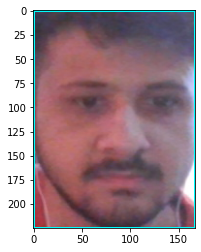

In [14]:
plt.imshow(faces[0])

In [14]:
frame = cv2.imread("twopersons.jpg")
(h, w) = frame.shape[:2]
blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),
    (104.0, 177.0, 123.0))

faceNet.setInput(blob)
detections = faceNet.forward()
faces = []
for i in range(0, detections.shape[2]):
    confidence = detections[0, 0, i, 2]

    if confidence > 0.5:
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")

        (startX, startY) = (max(0, startX), max(0, startY))
        (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

        faceimage = frame[startY:endY, startX:endX]

        faceimage = faceimage[:, :, ::-1]
        faces.append(faceimage)
        face_encodings = face_recognition.face_encodings(faceimage)
        
    break

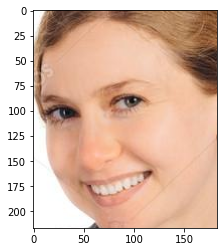

In [18]:
plt.imshow(faces[1])